In [1]:
import os
import numpy as np
import pynbody
from pynbody.plot import sph
import matplotlib.pylab as plt

from snap_io import load_moria_sim_and_kicked, load_moria, load_kicked, load_sim

In [2]:
SIMNUMBER = "69002_p200.0_a600.0_r600.0_c8.15"
kicked=True

In [3]:
resolution = 500
width = 10 # kpc
vmax=2e-1
vmin=5e-4;

In [4]:
snap_list = load_kicked(SIMNUMBER) if kicked else load_moria(SIMNUMBER)

In [5]:
s = snap_list[0]

In [6]:
# # pynbody.analysis.angmom.faceon(sim)

In [7]:
# fig, ax = plt.subplots(figsize=(10,10))
# sph.image(sim.g, subplot=ax, qty="rho", resolution=500, units="g cm^-3",
#           width=10, log=False);
# time = '$t={%5.2f}$ Gyr' % sim.properties['time'].in_units("Gyr")
# ax.set_title(time, fontsize=12)

In [8]:
def gas_orthogonal_projection(sim, qty='rho', **kwargs):
    sim.properties.pop('boxsize', None)
    sim.g['smooth'] /= 2
    pynbody.analysis.halo.center(sim, shrink_factor=0.9)
    fig, ((ax_xy, ax_zy), (ax_xz, ax_angmom)) = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
    kwargs['ret_im']=True
    if "units" not in kwargs:
        kwargs['units'] = "g cm^-2"
    u_st = sim['pos'].units.latex()
    backup = sim['pos'].copy()
    try:
        im = sph.image(sim.g, subplot=ax_xy, **kwargs)
        ax_xy.set_xlabel("$x/%s$" % u_st)
        ax_xy.set_ylabel("$y/%s$" % u_st)
        
        x=sim['pos'][:,0].copy()
        sim['pos'][:,0] = sim['pos'][:,2].copy()
        sph.image(sim.g, subplot=ax_zy, **kwargs)
        ax_zy.set_xlabel("$z/%s$" % u_st)
        ax_zy.set_ylabel("$y/%s$" % u_st)

        sim['pos'][:,1] = sim['pos'][:,2]
        sim['pos'][:,0] = x
        sph.image(sim.g, subplot=ax_xz, **kwargs)
        ax_xz.set_xlabel("$x/%s$" % u_st)
        ax_xz.set_ylabel("$z/%s$" % u_st)

        pynbody.analysis.angmom.faceon(sim)
        sim['pos'] = backup
        sph.image(sim.g, subplot=ax_angmom, **kwargs)
        ax_angmom.set_xlabel("$x/%s$" % u_st)
        ax_angmom.set_ylabel("$y/%s$" % u_st)
        ax_angmom.set_title("angular momentum faceon")
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.96, bottom=0.11)
        cbar_ax = fig.add_axes([0.2,  0.05, 0.6, 0.02])
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal').set_label(qty+"/"+kwargs['units'])
        
        snap = int(sim.filename[-4:])
        title = '$t={:5.2f}$ Gyr, snap={}'.format(sim.properties['time'].in_units("Gyr"), snap)
        fig.suptitle(title)
    finally:
        sim.g['smooth'] *= 2
        sim['pos'] = backup
    return fig

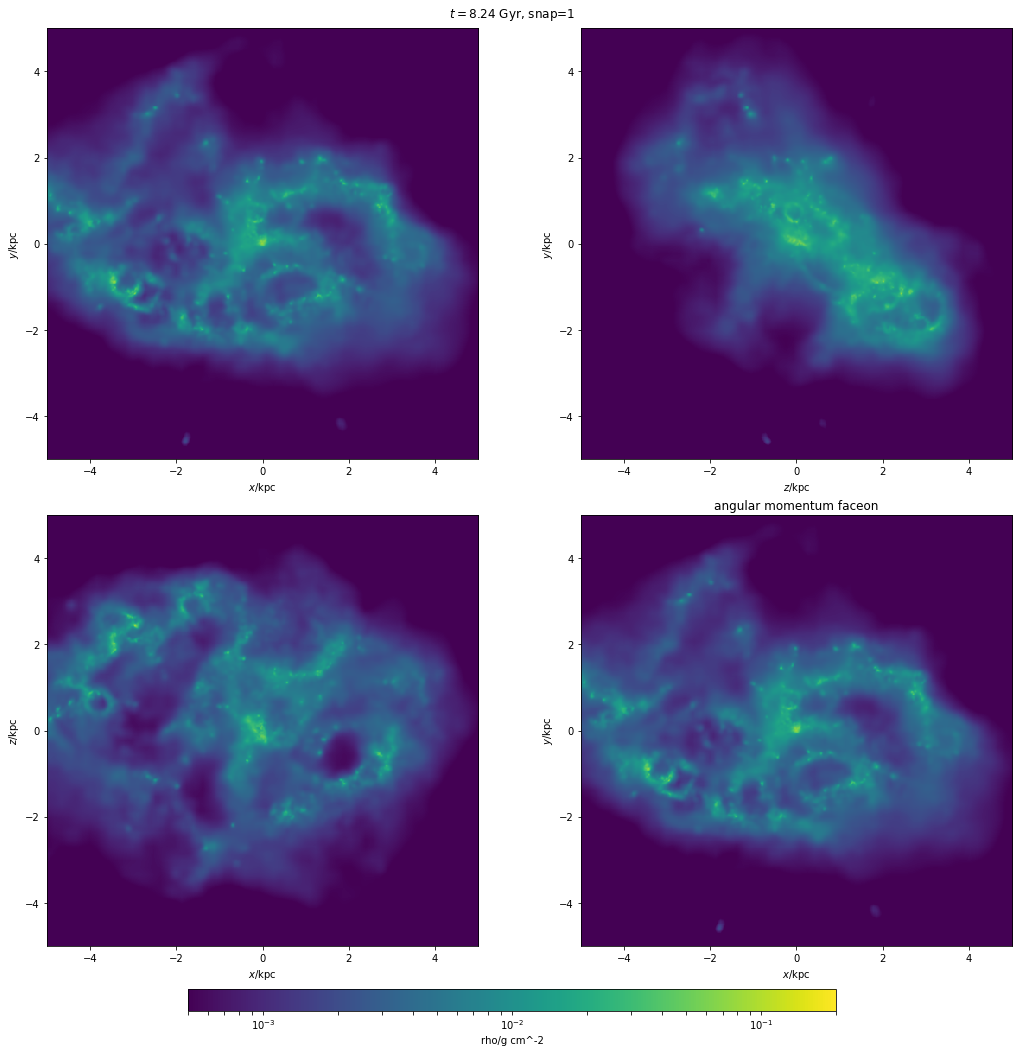

In [9]:
gas_orthogonal_projection(s, width=10, vmin=vmin, vmax=vmax, resolution=resolution);

In [10]:
# gas_orthogonal_projection(s, width=10, units="g cm^-3", resolution=resolution);

In [11]:
s['pos'][:,0]

SimArray([-6442.32421875, -4907.84863281, -5219.421875  , ...,
           -376.70684814,  -638.23205566,  -776.57531738], dtype=float32, 'kpc')

In [12]:
np.array([ -493.36032104,   138.26968384,    72.48400116]).mean()

-94.202212013333323

In [13]:
v=s['vel'].mean(axis=0)
v

SimArray([-1.44949186, -1.1948632 , -0.25161353], dtype=float32, 'km s**-1')

In [14]:
np.linalg.norm(v)

1.8952663

In [15]:
from numba import jit
@jit
def gas_velocity_lateral_view_jit(sim, width=10, vmin=vmin, vmax=vmax, resolution=resolution):
    sim.properties.pop('boxsize', None)
    sim.g['smooth'] /= 2
    pynbody.analysis.halo.center(sim, shrink_factor=0.9)
    velocity = s['vel'].mean(axis=0)
    backup = sim['pos'].copy()
    v_modulus = np.linalg.norm(velocity)
    x_p = (velocity[1] * sim['pos'][:,0] + velocity[0] * sim['pos'][:,1])/v_modulus 
    y_p = (- velocity[0] * sim['pos'][:,0] + velocity[1] * sim['pos'][:,1])/v_modulus
    sim['pos'][:,0] = x_p
    sim['pos'][:,1] = y_p
#     try:
    img = sph.image(sim.g, qty="rho", units="g cm^-2", width=10, vmin=vmin, vmax=vmax, resolution=resolution)
#     finally:
    sim.g['smooth'] *= 2
    sim['pos'] = backup
    return img

In [16]:
import contextlib

@contextlib.contextmanager
def np_printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

In [17]:
def gas_velocity_lateral_view(sim, **kwargs):
    sim.properties.pop('boxsize', None)
    sim.g['smooth'] /= 2
    pynbody.analysis.halo.center(sim, shrink_factor=0.9)
    velocity = sim['vel'].mean(axis=0)
    backup = sim['pos'].copy()
    v_modulus = np.linalg.norm(velocity)
    x_p = (velocity[1] * sim['pos'][:,0] + velocity[0] * sim['pos'][:,1])/v_modulus 
    y_p = (- velocity[0] * sim['pos'][:,0] + velocity[1] * sim['pos'][:,1])/v_modulus
    sim['pos'][:,0] = x_p
    sim['pos'][:,1] = y_p
    try:
        snap = int(sim.filename[-4:])
        with np_printoptions(precision=2):
            title = '$t={:5.2f}$ Gyr, snap={}\nv = {}'.format(sim.properties['time'].in_units("Gyr"), snap, velocity)
        img = sph.image(sim.g, qty="rho", units="g cm^-2", title=title, **kwargs)
    finally:
        sim.g['smooth'] *= 2
        sim['pos'] = backup
    return img

In [18]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(i):
    gas_velocity_lateral_view(snap_list[i], width=width, vmin=vmin, vmax=vmax, resolution=resolution)
def g(i):
    gas_orthogonal_projection(snap_list[i], width=width, vmin=vmin, vmax=vmax, resolution=resolution)

In [19]:
interact(f, i=widgets.IntSlider(min=0,max=len(snap_list),step=1,value=0, continuous_update=False));
interact(g, i=widgets.IntSlider(min=0,max=len(snap_list),step=1,value=0, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=95), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=95), Output()), _dom_classes=('widget-interact',))

In [20]:
vmax=2e-1
vmin=5e-4;

In [21]:
def h(i, vrange):
    gas_orthogonal_projection(snap_list[i], width=width, vmin=vrange[0], vmax=vrange[1], resolution=resolution)

In [22]:
vminmax = widgets.FloatRangeSlider(
    value=[vmin, vmax],
    min=1e-5,
    max=1e-2,
    step=1e-5,
    description='Value:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='1.0e',
)
interact(h, i=widgets.IntSlider(min=0,max=len(snap_list),step=1,value=0, continuous_update=False),
            vrange=vminmax);


interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=95), FloatRangeSlider(value=(0.0005, 0.01), continuous_update=False, description='Value:', max=0.01, min=1e-05, readout_format='1.0e', step=1e-05), Output()), _dom_classes=('widget-interact',))

In [23]:
# folder = "pngs_{}".format(SIMNUMBER)
# os.makedirs(folder,exist_ok=True )

In [24]:
# for sim in snap_list[0:3]:
#     snap = int(sim.filename[-4:])
#     fig, ax = plt.subplots(figsize=(15,15))
#     filename = os.path.join(folder,"gas_image_{}_{}.png".format(SIMNUMBER,snap))
#     title = '$t={:5.2f}$ Gyr, snap={}'.format(sim.properties['time'].in_units("Gyr"), snap)
#     gas_image(sim, width=width, vmin=vmin, vmax=vmax, resolution=resolution, title=title, filename=filename);
#     print("Saved", filename)